<a href="https://colab.research.google.com/github/qlqqqk/Aiffel_prac/blob/main/EXP/%5BE_14%5DGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers.convolutional import UpSampling2D, Conv2D
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print('tensorflow', tf.__version__)

tensorflow 2.8.2


In [ ]:
#CIFAR10 load
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 2s 0us/step


(50000, 32, 32, 3)

In [ ]:
print('Max pixel:', train_x.max())
print('Min pixel:', train_x.min())
# 이미지를 [-1, 1] 로 정규화하기 위한 작업
train_x = (train_x - 127.5) / 127.5 

print('Max pixel:', train_x.max())
print('Min pixel:', train_x.min())

Max pixel: 255
Min pixel: 0
Max pixel: 1.0
Min pixel: -1.0


In [ ]:
train_x.shape

(50000, 32, 32, 3)

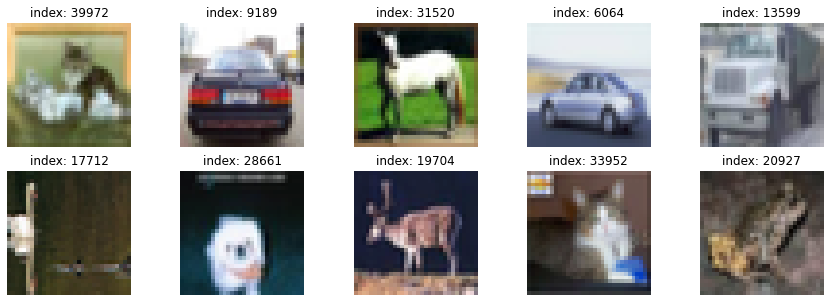

In [ ]:
plt.figure(figsize=(15, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index] + 1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

## 로스,평가함수 설정

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
    
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 최적화함수

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 학습 파라미터

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 초기 모델 설정

In [ ]:
def make_generator_model_zero():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model


generator_zero = make_generator_model_zero()

generator_zero.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_10 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_11 (Bat  (None, 8, 8, 128)       

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator_zero(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

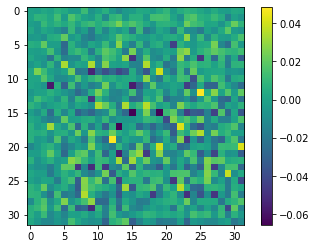

In [ ]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [ ]:
def make_discriminator_model_zero():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model


discriminator_zero = make_discriminator_model_zero()

discriminator_zero.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)             

In [ ]:
decision = discriminator_zero(generated_image, training=False)

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_zero(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator_zero(images, training=True)
        fake_output = discriminator_zero(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_zero.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_zero.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_zero.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_zero.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
        
    plt.savefig('/content/drive/MyDrive/Aiffel/data/fashion/generated_samples/EX00_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    
    plt.show()

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 # matlab 차트의 기본 크기를 15, 6 으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.xlabel('batch iters')
    plt.ylabel('accuracy')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # training_history 디렉토리에 epoch 별로 그래프를 이미지 파일로 저장
    plt.savefig('/content/drive/MyDrive/Aiffel/data/fashion/training_history/EX00_train_history_{:04d}.png'.format(epoch))
    
    plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Aiffel/data/fashion/EX00_training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_zero,
                                 discriminator=discriminator_zero)

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_zero, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_zero, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 100

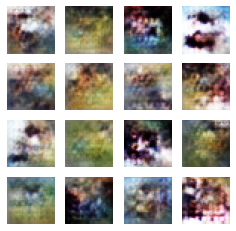

Time for training : 1029 sec


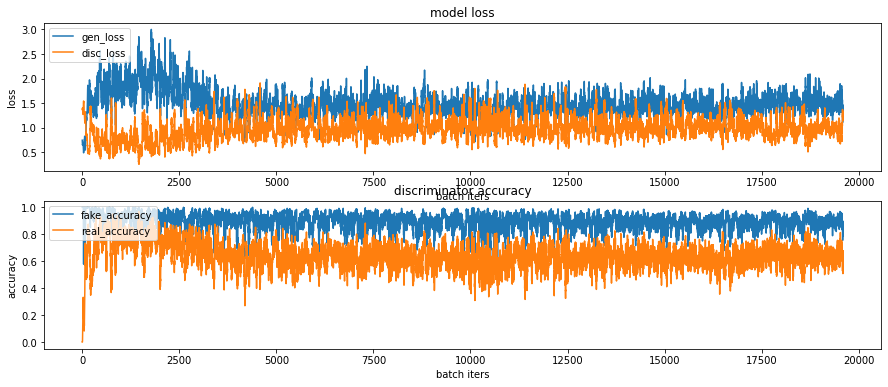

CPU times: user 17min 29s, sys: 41.5 s, total: 18min 10s
Wall time: 17min 10s


In [ ]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/Aiffel/data/fashion/EX00_fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Aiffel/data/fashion/generated_samples/EX00_epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/Aiffel/data/fashion/EX00_fashion_mnist_dcgan.gif

-rw------- 1 root root 1867801 Jun 16 11:21 /content/drive/MyDrive/Aiffel/data/fashion/EX00_fashion_mnist_dcgan.gif


In [ ]:
anim_file = '/content/drive/MyDrive/Aiffel/data/fashion/EX00_fashion_loss_accuracy.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Aiffel/data/fashion/training_history/EX00_train_history*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/Aiffel/data/fashion/EX00_fashion_loss_accuracy.gif

-rw------- 1 root root 2334888 Jun 16 11:21 /content/drive/MyDrive/Aiffel/data/fashion/EX00_fashion_loss_accuracy.gif


## 모델 조정

In [ ]:
def make_generator_model_one():

  model = tf.keras.Sequential()
  
  # first: Dense layer
  model.add(layers.Dense(8 * 8 * 128, activation='relu', input_shape=(100,)))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))
  
  # second: Reshape layer
  model.add(layers.Reshape((8, 8, 128)))

  # third: Conv2D layer
  model.add(layers.Conv2D(128, kernel_size=4, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # fourth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # fifth: Conv2D layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1,padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # sixth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # seventh: Conv2D layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
  model.add(layers.BatchNormalization(momentum=0.9))
  model.add(layers.LeakyReLU(alpha=0.1))

  # eigth: Conv2D layer                   
  model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding="same", activation='tanh'))
  
  return model

In [ ]:
generator_one = make_generator_model_one()

generator_one.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_23 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 8, 128)         262272    
                                                                 
 batch_normalization_24 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                     

In [ ]:
# 노이즈를 생성합니다.
noise = tf.random.normal([1, 100])
generated_image = generator_one(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

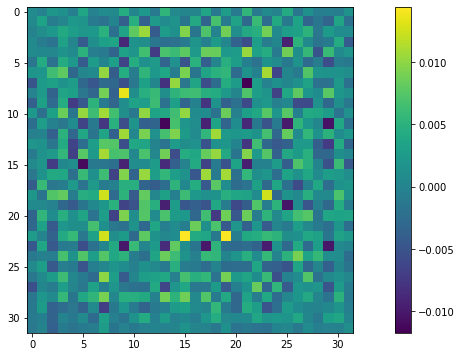

In [ ]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [ ]:
def make_discriminator_model_one():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=3, strides=1, input_shape=(32, 32, 3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))


    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator_one = make_discriminator_model_one()

discriminator_one.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_29 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_10 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 128)       262272    
                                                                 
 batch_normalization_30 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                     

In [ ]:
decision = discriminator_one(generated_image, training=False)

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator_one(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator_one(images, training=True)
        fake_output = discriminator_one(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_one.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_one.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_one.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_one.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
        
    plt.savefig('/content/drive/MyDrive/Aiffel/data/fashion/generated_samples/EX01_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    
    plt.show()

In [ ]:
def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.xlabel('batch iters')
    plt.ylabel('accuracy')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    # training_history 디렉토리에 epoch 별로 그래프를 이미지 파일로 저장
    plt.savefig('/content/drive/MyDrive/Aiffel/data/fashion/training_history/EX01_train_history_{:04d}.png'.format(epoch))
    
    plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Aiffel/data/fashion/EX01_training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_one,
                                 discriminator=discriminator_one)

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator_one, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator_one, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 300

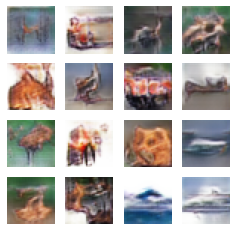

Time for training : 12779 sec


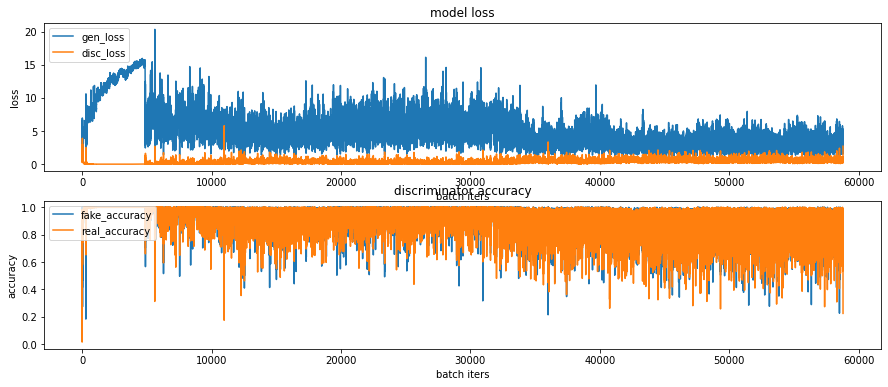

CPU times: user 3h 33min 40s, sys: 1min 52s, total: 3h 35min 33s
Wall time: 3h 33min 2s


In [ ]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/Aiffel/data/fashion/EX01_fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Aiffel/data/fashion/generated_samples/EX01_epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/AIFFEL/data/fashion/EX01_fashion_mnist_dcgan.gif

ls: cannot access '/content/drive/MyDrive/AIFFEL/data/fashion/EX01_fashion_mnist_dcgan.gif': No such file or directory


In [ ]:
anim_file = '/content/drive/MyDrive/Aiffel/data/fashion/EX01_fashion_loss_accuracy.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/Aiffel/data/fashion/training_history/EX01_train_history*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/drive/MyDrive/AIFFEL/data/fashion/EX01_fashion_loss_accuracy.gif

ls: cannot access '/content/drive/MyDrive/AIFFEL/data/fashion/EX01_fashion_loss_accuracy.gif': No such file or directory
